In [2]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns 

# set the plotting style 
sns.set_style("whitegrid")

# plot tree model
import graphviz

# Plot missing values
import missingno as msno

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Train-test splits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Models
from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

# Imputation
from sklearn.impute import KNNImputer
#from fancyimpute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

## Clean the data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/he-chang/data5100project/main/university_data.csv')

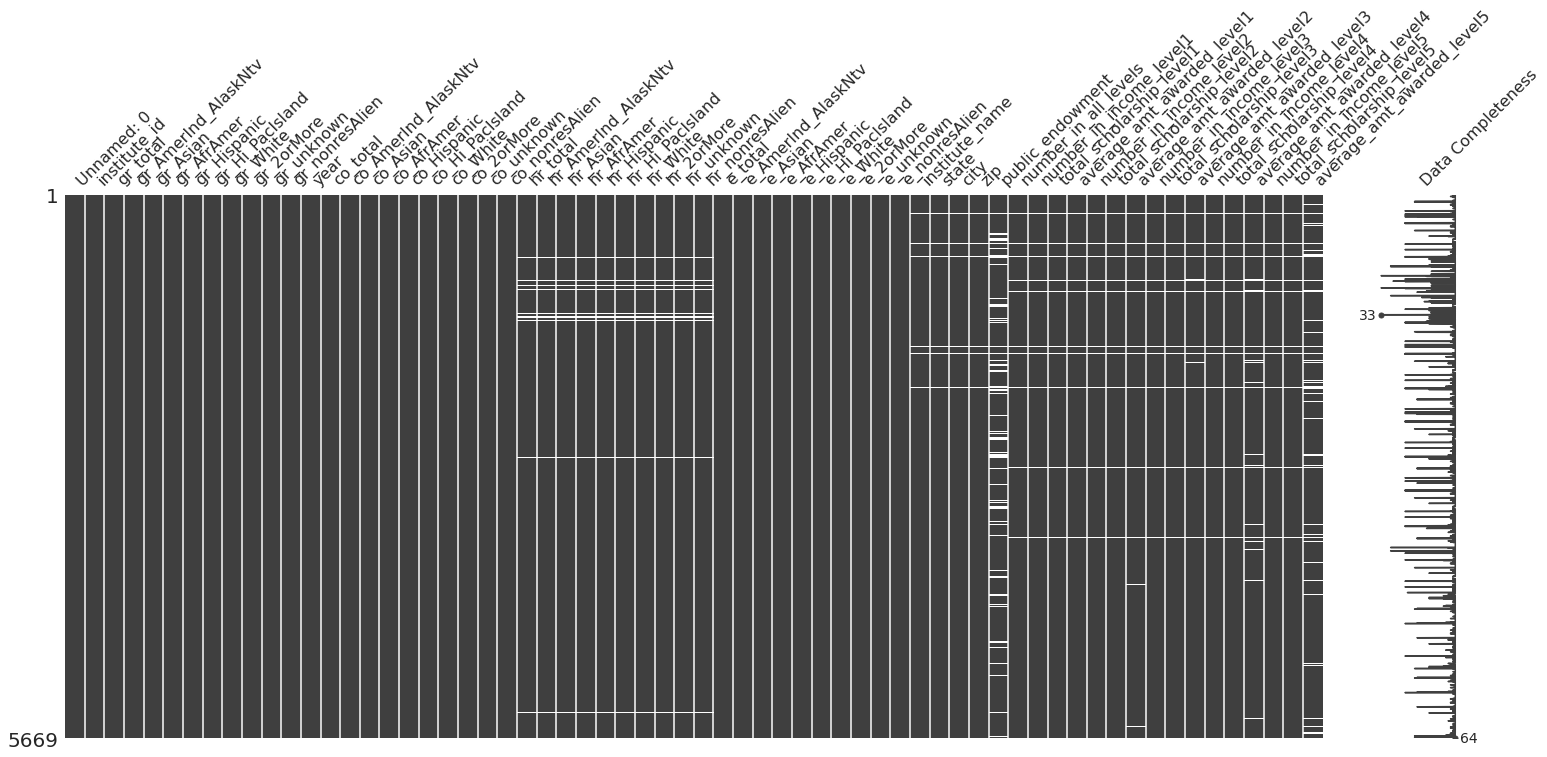

In [4]:
msno.matrix(df, labels = True);

The missing elements appeared most for hr values, endowments, and financial aid information was missing more.  Missing endowments and average amount awarded per income levels were assumed to be 0 if not reported.

In [5]:
df['public_endowment'] = df['public_endowment'].fillna(0)
df['average_amt_awarded_level2'] = df['average_amt_awarded_level2'].fillna(0)
df['average_amt_awarded_level3'] = df['average_amt_awarded_level3'].fillna(0)
df['average_amt_awarded_level4'] = df['average_amt_awarded_level4'].fillna(0)
df['average_amt_awarded_level5'] = df['average_amt_awarded_level5'].fillna(0)

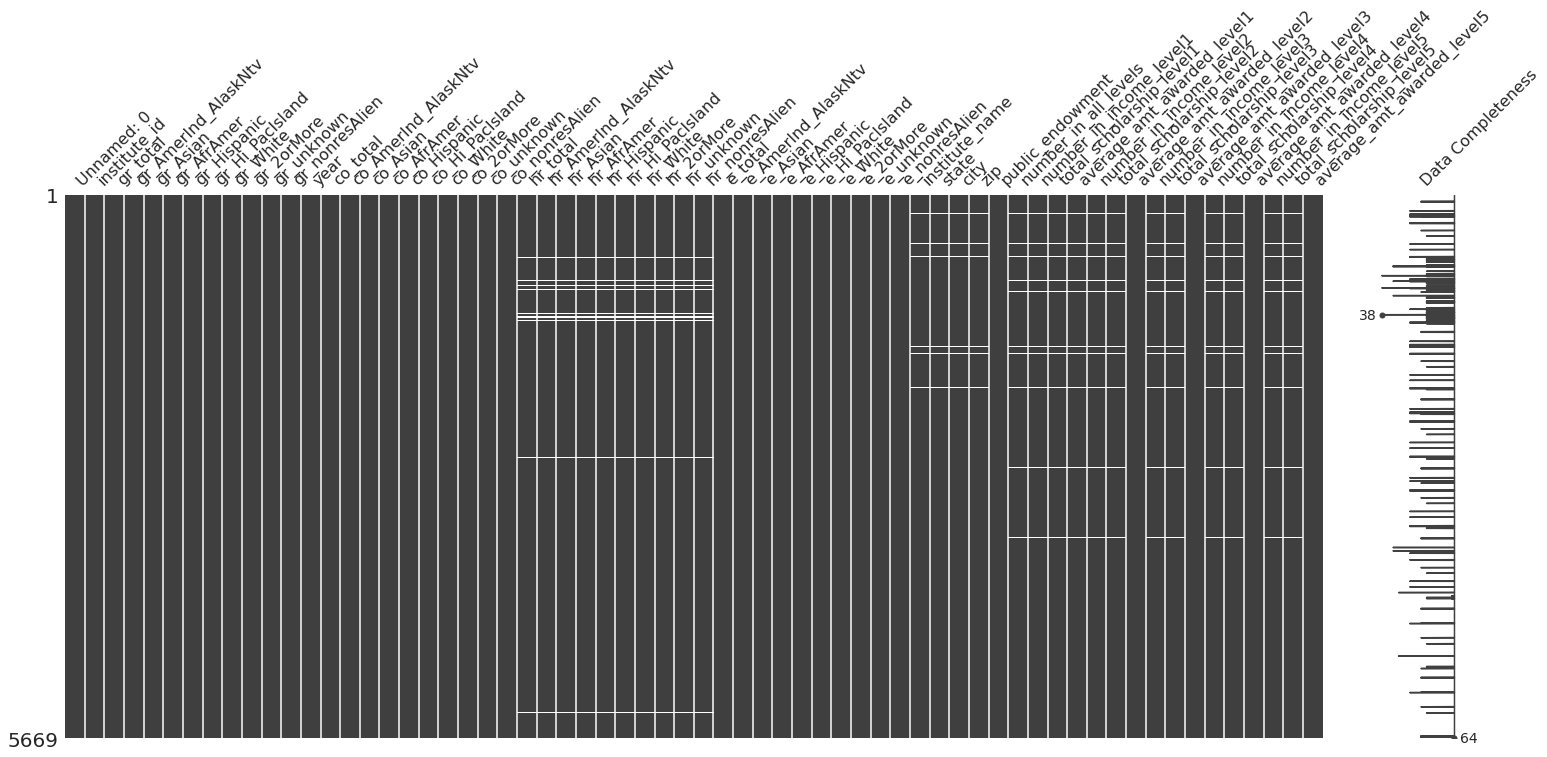

In [6]:
msno.matrix(df, labels = True);

In [7]:
# The remaning rows with missing information were dropped because they appeared random.
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5436 entries, 0 to 5668
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  5436 non-null   int64  
 1   institute_id                5436 non-null   int64  
 2   gr_total                    5436 non-null   float64
 3   gr_AmerInd_AlaskNtv         5436 non-null   float64
 4   gr_Asian                    5436 non-null   float64
 5   gr_AfrAmer                  5436 non-null   float64
 6   gr_Hispanic                 5436 non-null   float64
 7   gr_Hi_PacIsland             5436 non-null   float64
 8   gr_White                    5436 non-null   float64
 9   gr_2orMore                  5436 non-null   float64
 10  gr_unknown                  5436 non-null   float64
 11  gr_nonresAlien              5436 non-null   float64
 12  year                        5436 non-null   int64  
 13  co_total                    5436 

## Calculate Student Income Percentages

In [9]:
# Function to calculate the percentages
def calcPercentage(overall_total, group_total):
  if overall_total == 0:
    return 0
  else:
    return group_total / overall_total

In [10]:
income_groups = ['number_in_income_level1', 'number_in_income_level2', 'number_in_income_level3', 'number_in_income_level4', 'number_in_income_level5']

for group in income_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['number_in_all_levels'], x[group]), axis = 1)

In [11]:
def calculateRange(income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5):
  income_list = [income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5]
  income_max = max(income_list)
  income_min = min(income_list)
  return income_max - income_min

In [12]:
def calculateMax(income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5):
  income_list = [income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5]
  income_max = max(income_list)

  return income_list.index(income_max) + 1

In [13]:
df['income_range'] = df.apply(lambda x: calculateRange(x['number_in_income_level1_pct'], x['number_in_income_level2_pct'], x['number_in_income_level3_pct'], x['number_in_income_level4_pct'], x['number_in_income_level5_pct']), axis = 1)
df['income_level_majority'] = df.apply(lambda x: calculateMax(x['number_in_income_level1_pct'], x['number_in_income_level2_pct'], x['number_in_income_level3_pct'], x['number_in_income_level4_pct'], x['number_in_income_level5_pct']), axis = 1)

## Calculate Percentages and difference between total graduation rate and BiPOC graduation rate

In [14]:
def getCohortGroupTotal(group_name):
  new_group_name = group_name
  return new_group_name.replace("gr", "co")

In [15]:
cohort_groups = ['co_AmerInd_AlaskNtv', 'co_AmerInd_AlaskNtv', 'co_AmerInd_AlaskNtv', 'co_Asian', 'co_AfrAmer', 'co_Hispanic', 'co_Hi_PacIsland', 'co_White', 'co_2orMore', 'co_unknown', 'co_nonresAlien']

for group in cohort_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['co_total'], x[group]), axis = 1)

df.head()

,Unnamed: 0,institute_id,gr_total,gr_AmerInd_AlaskNtv,gr_Asian,gr_AfrAmer,gr_Hispanic,gr_Hi_PacIsland,gr_White,gr_2orMore,...,income_level_majority,co_AmerInd_AlaskNtv_pct,co_Asian_pct,co_AfrAmer_pct,co_Hispanic_pct,co_Hi_PacIsland_pct,co_White_pct,co_2orMore_pct,co_unknown_pct,co_nonresAlien_pct
0,0,100654,257.0,0.0,0.0,252.0,1.0,0.0,2.0,0.0,...,1,0.001134,0.000000,0.977324,0.005669,0.0,0.010204,0.000000,0.000000,0.005669
1,1,100663,741.0,2.0,51.0,181.0,17.0,0.0,441.0,19.0,...,1,0.002177,0.054427,0.253266,0.019594,0.0,0.605951,0.021771,0.026125,0.016691
2,2,100706,367.0,10.0,13.0,50.0,6.0,0.0,264.0,7.0,...,1,0.019763,0.026350,0.139657,0.022398,0.0,0.747036,0.014493,0.003953,0.026350
3,3,100724,340.0,0.0,0.0,332.0,1.0,0.0,1.0,2.0,...,1,0.000000,0.000000,0.974093,0.002961,0.0,0.008882,0.001480,0.009623,0.002961
4,4,100751,2958.0,15.0,36.0,214.0,55.0,0.0,2623.0,0.0,...,1,0.004507,0.011492,0.085174,0.017125,0.0,0.876521,0.000000,0.000000,0.005183


In [16]:
grad_groups = ['gr_total', 'gr_AmerInd_AlaskNtv', 'gr_Asian', 'gr_AfrAmer', 'gr_Hispanic', 'gr_Hi_PacIsland', 'gr_White', 'gr_2orMore', 'gr_unknown', 'gr_nonresAlien']

for group in grad_groups:
  new_column_name = group + "_pct"
  total_group = getCohortGroupTotal(group)
  df[new_column_name] = df.apply(lambda x: calcPercentage(x[total_group], x[group]), axis = 1)

df.head()

,Unnamed: 0,institute_id,gr_total,gr_AmerInd_AlaskNtv,gr_Asian,gr_AfrAmer,gr_Hispanic,gr_Hi_PacIsland,gr_White,gr_2orMore,...,gr_total_pct,gr_AmerInd_AlaskNtv_pct,gr_Asian_pct,gr_AfrAmer_pct,gr_Hispanic_pct,gr_Hi_PacIsland_pct,gr_White_pct,gr_2orMore_pct,gr_unknown_pct,gr_nonresAlien_pct
0,0,100654,257.0,0.0,0.0,252.0,1.0,0.0,2.0,0.0,...,0.291383,0.000000,0.000000,0.292343,0.200000,0.0,0.222222,0.000000,0.000000,0.400000
1,1,100663,741.0,2.0,51.0,181.0,17.0,0.0,441.0,19.0,...,0.537736,0.666667,0.680000,0.518625,0.629630,0.0,0.528144,0.633333,0.416667,0.652174
2,2,100706,367.0,10.0,13.0,50.0,6.0,0.0,264.0,7.0,...,0.483531,0.666667,0.650000,0.471698,0.352941,0.0,0.465608,0.636364,0.666667,0.750000
3,3,100724,340.0,0.0,0.0,332.0,1.0,0.0,1.0,2.0,...,0.251665,0.000000,0.000000,0.252280,0.250000,0.0,0.083333,1.000000,0.307692,0.000000
4,4,100751,2958.0,15.0,36.0,214.0,55.0,0.0,2623.0,0.0,...,0.666516,0.750000,0.705882,0.566138,0.723684,0.0,0.674293,0.000000,0.000000,0.652174


In [17]:
enr_groups = ['e_AmerInd_AlaskNtv', 'e_Asian', 'e_AfrAmer', 'e_Hispanic', 'e_Hi_PacIsland', 'e_White', 'e_2orMore', 'e_unknown', 'e_nonresAlien']

for group in enr_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['e_total'], x[group]), axis = 1)
  
df.head()

,Unnamed: 0,institute_id,gr_total,gr_AmerInd_AlaskNtv,gr_Asian,gr_AfrAmer,gr_Hispanic,gr_Hi_PacIsland,gr_White,gr_2orMore,...,gr_nonresAlien_pct,e_AmerInd_AlaskNtv_pct,e_Asian_pct,e_AfrAmer_pct,e_Hispanic_pct,e_Hi_PacIsland_pct,e_White_pct,e_2orMore_pct,e_unknown_pct,e_nonresAlien_pct
0,0,100654,257.0,0.0,0.0,252.0,1.0,0.0,2.0,0.0,...,0.400000,0.001594,0.006375,0.922311,0.009761,0.000797,0.050996,0.000000,0.007968,0.000199
1,1,100663,741.0,2.0,51.0,181.0,17.0,0.0,441.0,19.0,...,0.652174,0.002585,0.048470,0.211601,0.026282,0.000754,0.638356,0.028221,0.012764,0.030967
2,2,100706,367.0,10.0,13.0,50.0,6.0,0.0,264.0,7.0,...,0.750000,0.012744,0.037419,0.117001,0.030369,0.000136,0.693736,0.014507,0.033080,0.061009
3,3,100724,340.0,0.0,0.0,332.0,1.0,0.0,1.0,2.0,...,0.000000,0.001481,0.002305,0.910288,0.011687,0.000658,0.033909,0.006255,0.013663,0.019753
4,4,100751,2958.0,15.0,36.0,214.0,55.0,0.0,2623.0,0.0,...,0.652174,0.004374,0.011683,0.114612,0.029955,0.001065,0.769970,0.019913,0.004086,0.044343


In [18]:
hr_groups = ['hr_AmerInd_AlaskNtv', 'hr_Asian', 'hr_AfrAmer', 'hr_Hispanic', 'hr_Hi_PacIsland', 'hr_White', 'hr_2orMore', 'hr_unknown']

for group in hr_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['hr_total'], x[group]), axis = 1)

df.head()

,Unnamed: 0,institute_id,gr_total,gr_AmerInd_AlaskNtv,gr_Asian,gr_AfrAmer,gr_Hispanic,gr_Hi_PacIsland,gr_White,gr_2orMore,...,e_unknown_pct,e_nonresAlien_pct,hr_AmerInd_AlaskNtv_pct,hr_Asian_pct,hr_AfrAmer_pct,hr_Hispanic_pct,hr_Hi_PacIsland_pct,hr_White_pct,hr_2orMore_pct,hr_unknown_pct
0,0,100654,257.0,0.0,0.0,252.0,1.0,0.0,2.0,0.0,...,0.007968,0.000199,0.002950,0.058997,0.761062,0.002950,0.002950,0.123894,0.000000,0.011799
1,1,100663,741.0,2.0,51.0,181.0,17.0,0.0,441.0,19.0,...,0.012764,0.030967,0.001647,0.134623,0.058872,0.028818,0.000000,0.748868,0.002470,0.000000
2,2,100706,367.0,10.0,13.0,50.0,6.0,0.0,264.0,7.0,...,0.033080,0.061009,0.002101,0.100840,0.046218,0.016807,0.000000,0.794118,0.000000,0.014706
3,3,100724,340.0,0.0,0.0,332.0,1.0,0.0,1.0,2.0,...,0.013663,0.019753,0.004890,0.066015,0.606357,0.012225,0.002445,0.229829,0.000000,0.078240
4,4,100751,2958.0,15.0,36.0,214.0,55.0,0.0,2623.0,0.0,...,0.004086,0.044343,0.000555,0.063298,0.063298,0.018323,0.000555,0.826763,0.002221,0.000000


In [19]:
# Staff BiPOC percentage = all non-white race and ethnicities staff counts added together / total staff

df['hr_BiPOC_pct'] = ((df['hr_AmerInd_AlaskNtv'] + df['hr_Asian'] + df['hr_AfrAmer'] + df['hr_Hispanic'] + df['hr_Hi_PacIsland'] + df['hr_2orMore'])/df['hr_total'])

In [20]:
# Cohort BiPOC Percentage = all non-white race and ethnicities cohort counts added together / total cohort size

df['co_BiPOC_pct'] = ((df['co_AmerInd_AlaskNtv'] + df['co_Asian'] + df['co_AfrAmer'] + df['co_Hispanic'] + df['co_Hi_PacIsland'] + df['co_2orMore'])/df['co_total'])

In [21]:
# BiPOC Graduation Percentage = all non-white race and ethnicities graduation counts added together / all non-white race and ethnicity group cohort counts added together

df['gr_BiPOC_pct'] = ((df['gr_AmerInd_AlaskNtv'] + df['gr_Asian'] + df['gr_AfrAmer'] + df['gr_Hispanic'] + df['gr_Hi_PacIsland'] + df['gr_2orMore'])/
                      ((df['co_AmerInd_AlaskNtv'] + df['co_Asian'] + df['co_AfrAmer'] + df['co_Hispanic'] + df['co_Hi_PacIsland'] + df['co_2orMore'])))

In [22]:
# BiPOC Enrollment Percentage = all non-white race and ethnicities enrollment counts added together / total enrollment count

df['e_BiPOC_pct'] = ((df['e_AmerInd_AlaskNtv'] + df['e_Asian'] + df['e_AfrAmer'] + df['e_Hispanic'] + df['e_Hi_PacIsland'] + df['e_2orMore'])/df['e_total'])

In [23]:
# Calculate the difference between the total graduation rate and BiPOC graduation rate for each school
df['gr_BiPOC_diff_pct'] = (df['gr_total_pct'] - df['gr_BiPOC_pct'])
df['gr_BiPOC_White_diff_pct'] = (df['gr_White_pct'] - df['gr_BiPOC_pct'])

## Set Graphing Functions

In [24]:
def graphPlots(colx, coly, labelx, labely):
  # Set figure size
  plt.figure(figsize = (14, 8))

  # Setup scatter plot for 
  sns.scatterplot(data = df, x = colx, y = coly, color = 'blue', alpha = 0.4)

  # Label x and y axis
  plt.xlabel(labelx, fontsize = 18)
  plt.ylabel(labely, fontsize = 18)

  plt.ticklabel_format(style='plain')
  #plt.xlim(0.0, 1.0)
  #plt.ylim(0.0, 1.0)

  plt.tick_params(labelsize = 15);

In [25]:
def graphPlotsPerYear(colx, coly, labelx, labely, year):
  # Set figure size
  plt.figure(figsize = (14, 8))

  # Setup scatter plot for 
  sns.scatterplot(data = df[df['year'] == year], x = colx, y = coly)

  # Label x and y axis
  plt.xlabel(labelx, fontsize = 18)
  plt.ylabel(labely, fontsize = 18)

  #plt.xlim(0.0, 1.0)
  #plt.ylim(0.0, 1.0)

  plt.tick_params(labelsize = 15);

In [26]:
df.groupby('year')[['year', 'gr_BiPOC_pct']].mean()

,year,gr_BiPOC_pct
year,,
2013,2013.0,0.388427
2014,2014.0,0.404400
2015,2015.0,0.395135
2016,2016.0,0.388521
2017,2017.0,0.391309
2018,2018.0,0.409493
2019,2019.0,0.415631
2020,2020.0,0.419593


In [27]:
df.groupby('year')[['year', 'co_BiPOC_pct']].mean()

,year,co_BiPOC_pct
year,,
2013,2013.0,0.322621
2014,2014.0,0.318437
2015,2015.0,0.337228
2016,2016.0,0.363116
2017,2017.0,0.381453
2018,2018.0,0.388387
2019,2019.0,0.400319
2020,2020.0,0.411369


In [28]:
df.groupby('year')[['year', 'gr_total_pct']].mean()

,year,gr_total_pct
year,,
2013,2013.0,0.452162
2014,2014.0,0.464912
2015,2015.0,0.454980
2016,2016.0,0.451073
2017,2017.0,0.453576
2018,2018.0,0.467598
2019,2019.0,0.469816
2020,2020.0,0.474256


In [29]:
df.groupby('year')[['year', 'gr_BiPOC_White_diff_pct']].mean()

,year,gr_BiPOC_White_diff_pct
year,,
2013,2013.0,0.073585
2014,2014.0,0.075468
2015,2015.0,0.068413
2016,2016.0,0.075314
2017,2017.0,0.078300
2018,2018.0,0.070705
2019,2019.0,0.067317
2020,2020.0,0.067985


In [30]:
df.head()

,Unnamed: 0,institute_id,gr_total,gr_AmerInd_AlaskNtv,gr_Asian,gr_AfrAmer,gr_Hispanic,gr_Hi_PacIsland,gr_White,gr_2orMore,...,hr_Hi_PacIsland_pct,hr_White_pct,hr_2orMore_pct,hr_unknown_pct,hr_BiPOC_pct,co_BiPOC_pct,gr_BiPOC_pct,e_BiPOC_pct,gr_BiPOC_diff_pct,gr_BiPOC_White_diff_pct
0,0,100654,257.0,0.0,0.0,252.0,1.0,0.0,2.0,0.0,...,0.002950,0.123894,0.000000,0.011799,0.828909,0.984127,0.291475,0.940837,-0.000091,-0.069252
1,1,100663,741.0,2.0,51.0,181.0,17.0,0.0,441.0,19.0,...,0.000000,0.748868,0.002470,0.000000,0.226431,0.351234,0.557851,0.317913,-0.020115,-0.029708
2,2,100706,367.0,10.0,13.0,50.0,6.0,0.0,264.0,7.0,...,0.000000,0.794118,0.000000,0.014706,0.165966,0.222661,0.508876,0.212175,-0.025345,-0.043267
3,3,100724,340.0,0.0,0.0,332.0,1.0,0.0,1.0,2.0,...,0.002445,0.229829,0.000000,0.078240,0.691932,0.978534,0.253404,0.932675,-0.001739,-0.170071
4,4,100751,2958.0,15.0,36.0,214.0,55.0,0.0,2623.0,0.0,...,0.000555,0.826763,0.002221,0.000000,0.148251,0.118297,0.609524,0.181601,0.056993,0.064769


## Visualizations

In [51]:
#sns.pairplot(df[['e_BiPOC_pct', 'co_BiPOC_pct', 'hr_BiPOC_pct', 'public_endowment', 'income_range', 
#                 'number_in_income_level1_pct', 'number_in_income_level2_pct', 'number_in_income_level3_pct', 'number_in_income_level4_pct', 'number_in_income_level5_pct', 'gr_BiPOC_pct']])

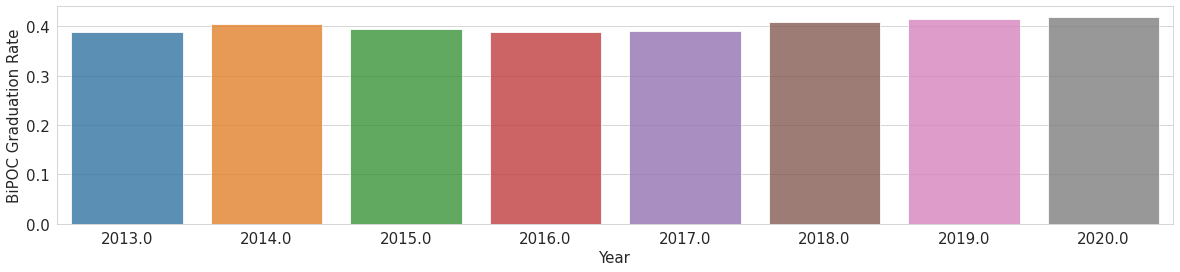

In [32]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'gr_BiPOC_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'gr_BiPOC_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("BiPOC Graduation Rate", fontsize = 15)
plt.tick_params(labelsize = 15);

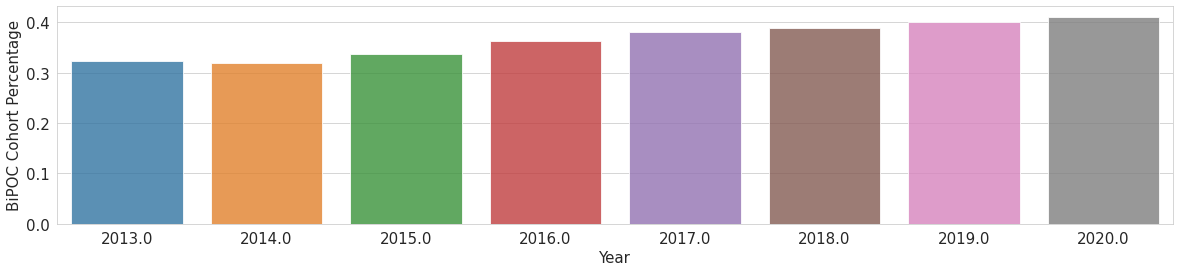

In [33]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'co_BiPOC_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'co_BiPOC_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("BiPOC Cohort Percentage", fontsize = 15)
plt.tick_params(labelsize = 15);

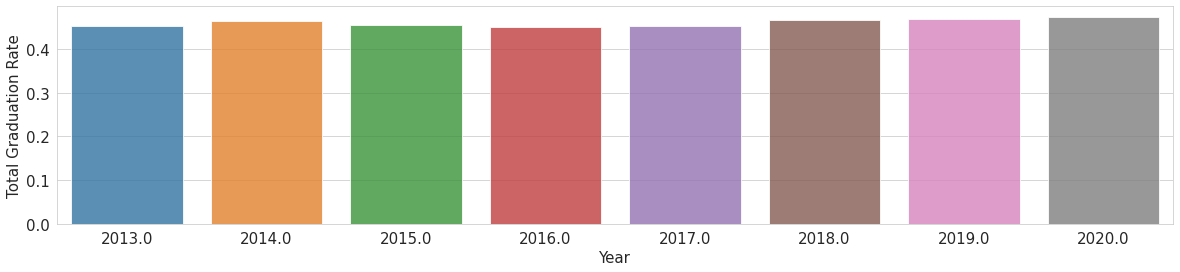

In [34]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'gr_total_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'gr_total_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("Total Graduation Rate", fontsize = 15)
plt.tick_params(labelsize = 15);

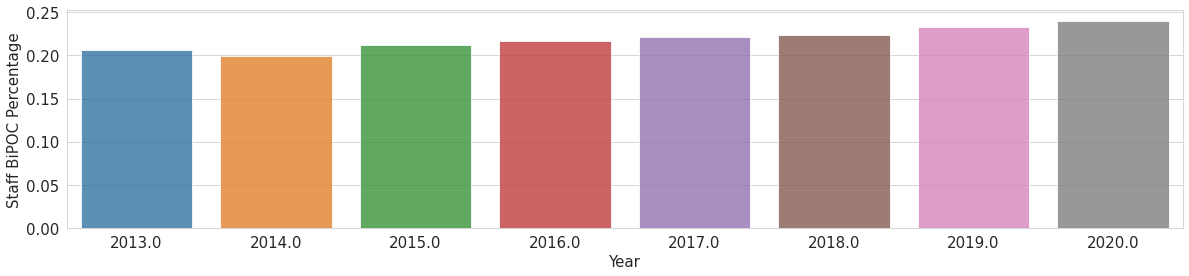

In [35]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'hr_BiPOC_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'hr_BiPOC_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("Staff BiPOC Percentage", fontsize = 15)
plt.tick_params(labelsize = 15);

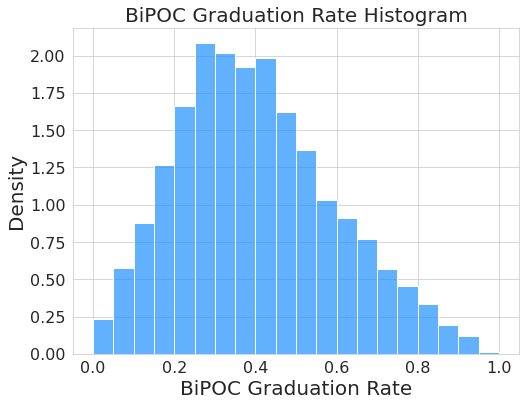

In [36]:
plt.figure(figsize = (8,6))

# Setup histogram plot
sns.histplot(data = df, x = 'gr_BiPOC_pct', bins = 20, color = 'dodgerblue', alpha = 0.7, stat = 'density')

# Label x and y axis
plt.xlabel('BiPOC Graduation Rate', fontsize = 20)
plt.ylabel('Density', fontsize = 20)

plt.title('BiPOC Graduation Rate Histogram', fontsize = 20)
plt.tick_params(labelsize = 16)

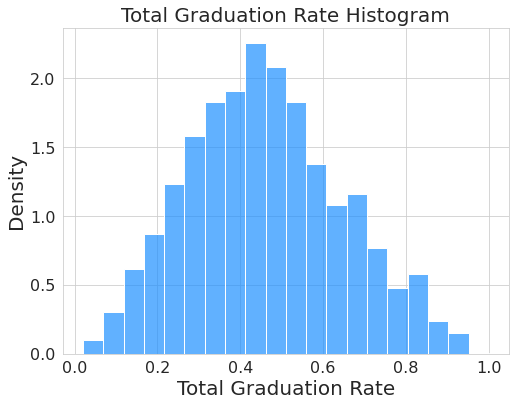

In [37]:
plt.figure(figsize = (8,6))

# Setup histogram plot
sns.histplot(data = df, x = 'gr_total_pct', bins = 20, color = 'dodgerblue', alpha = 0.7, stat = 'density')

# Label x and y axis
plt.xlabel('Total Graduation Rate', fontsize = 20)
plt.ylabel('Density', fontsize = 20)

plt.title('Total Graduation Rate Histogram', fontsize = 20)
plt.tick_params(labelsize = 16)

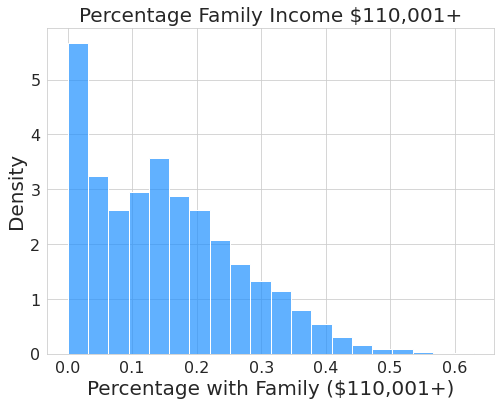

In [38]:
plt.figure(figsize = (8,6))

# Setup histogram plot
sns.histplot(data = df, x = 'number_in_income_level5_pct', bins = 20, color = 'dodgerblue', alpha = 0.7, stat = 'density')

# Label x and y axis
plt.xlabel('Percentage with Family ($110,001+)', fontsize = 20)
plt.ylabel('Density', fontsize = 20)

plt.title('Percentage Family Income $110,001+', fontsize = 20)
plt.tick_params(labelsize = 16)

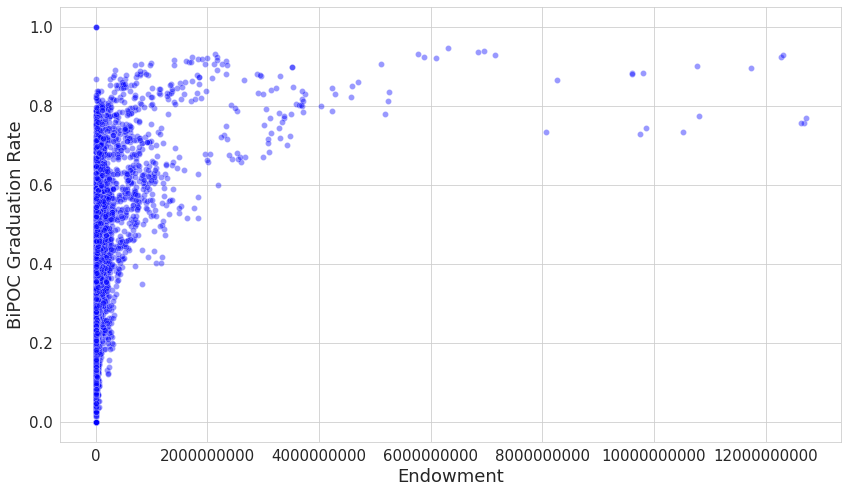

In [39]:
graphPlots('public_endowment', 'gr_BiPOC_pct', "Endowment", "BiPOC Graduation Rate")

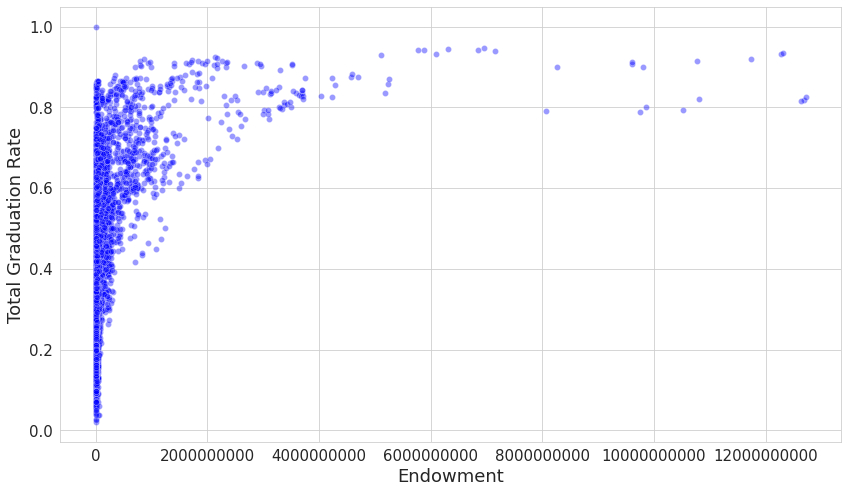

In [40]:
graphPlots('public_endowment', 'gr_total_pct', "Endowment", "Total Graduation Rate")

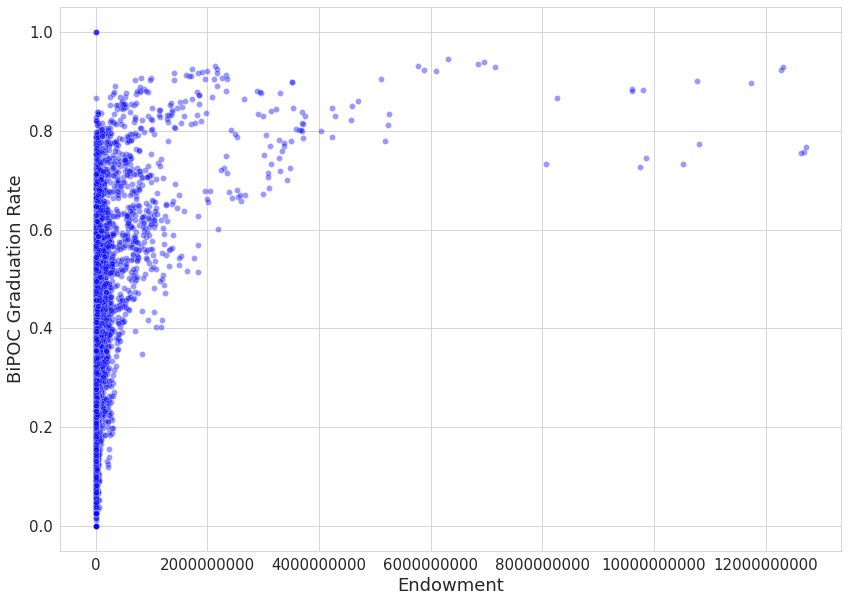

In [41]:
# Set figure size
plt.figure(figsize = (14, 10))

# Setup scatter plot for 
sns.scatterplot(data = df, x = 'public_endowment', y = 'gr_BiPOC_pct', color = 'blue', alpha = 0.4)

# Label x and y axis
plt.xlabel('Endowment', fontsize = 18)
plt.ylabel('BiPOC Graduation Rate', fontsize = 18)

plt.ticklabel_format(style='plain')
#plt.xlim(0.0, 1.0)
#plt.ylim(0.0, 1.0)

plt.tick_params(labelsize = 15);

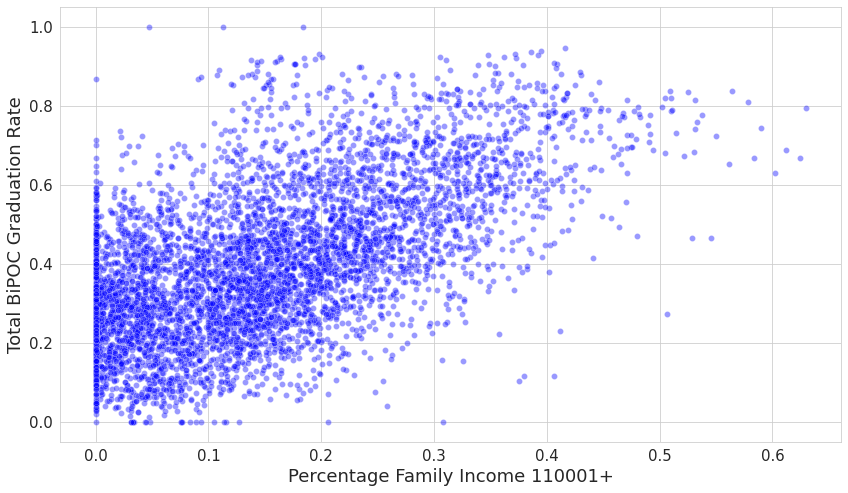

In [42]:
graphPlots('number_in_income_level5_pct', 'gr_BiPOC_pct', "Percentage Family Income 110001+", "Total BiPOC Graduation Rate")

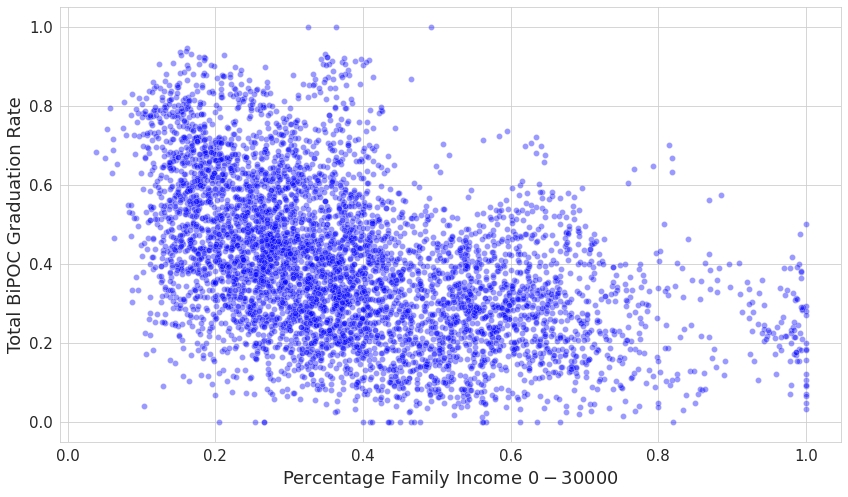

In [43]:
graphPlots('number_in_income_level1_pct', 'gr_BiPOC_pct', "Percentage Family Income $0 - $30000", "Total BiPOC Graduation Rate")

## BiPOC Graduation Rate Modeling

In [52]:
df_clean = df.dropna()
X = df_clean[['e_BiPOC_pct', 'co_BiPOC_pct', 'hr_BiPOC_pct', 'public_endowment', 'income_range', 'number_in_income_level1_pct', 'number_in_income_level2_pct', 'number_in_income_level3_pct', 'number_in_income_level4_pct', 'number_in_income_level5_pct']]
y = df_clean['gr_BiPOC_pct']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

In [54]:
df_pred = pd.concat([X_test, y_test], axis = 1)

df_pred.head()

,e_BiPOC_pct,co_BiPOC_pct,hr_BiPOC_pct,public_endowment,income_range,number_in_income_level1_pct,number_in_income_level2_pct,number_in_income_level3_pct,number_in_income_level4_pct,number_in_income_level5_pct,gr_BiPOC_pct
3312,0.119478,0.102093,0.119380,61090095.0,0.146624,0.294304,0.204641,0.166667,0.186709,0.147679,0.375000
1932,0.114085,0.085539,0.105556,404522000.0,0.086842,0.160526,0.163158,0.184211,0.247368,0.244737,0.757848
3534,0.631058,0.715385,0.253776,44728060.0,0.313725,0.412565,0.223689,0.161665,0.103241,0.098840,0.508649
4376,0.675980,0.725502,0.295154,182002529.0,0.281174,0.383777,0.214891,0.167676,0.102603,0.131053,0.567941
211,0.084501,0.072222,0.044313,31634000.0,0.186851,0.311419,0.166090,0.202422,0.195502,0.124567,0.276923


## Polynomial Attempt

In [3]:
# Highest degree polynomial
N = 3

# Polynomial degrees
d = np.arange(N) + 1

# Initialize
Rsquared = np.zeros(N)
MSE = np.zeros(N)

In [4]:
# Do regression analysis for each polynomial order
for n in d:

    # Create the design matrix for the training data
    X_train = PolynomialFeatures(degree=n, include_bias=False).fit_transform(X_train)

    # Create the design matrix for the test data
    X_test = PolynomialFeatures(degree=n, include_bias=False).fit_transform(X_test)

    # Create an instance of a linear regression model
    model_lr = linear_model.LinearRegression()

    # Fit the model on the training data
    model_lr.fit(X_train, y_train)

    # Get model predictions at test X values
    pred_lin_reg = model_lr.predict(X_test)

    # Assess model fit
    Rsquared[n-1] = r2_score(y_test, pred_lin_reg)

    MSE[n-1] = mean_squared_error(y_test, pred_lin_reg)

NameError: ignored

In [1]:
plt.subplots(1,2,figsize = (15,6))

# Plot R-squared
plt.subplot(1,2,1)
plt.plot(d,Rsquared,'o-')
plt.xlabel('Polynomial degree', fontsize = 14)
plt.ylabel('R-squared', fontsize = 14)
plt.tick_params(labelsize = 14)
#plt.ylim(0.4, 0.5)

# Plot MSE
plt.subplot(1,2,2)
plt.plot(d,MSE,'o-')
plt.xlabel('Polynomial degree', fontsize = 14)
plt.ylabel('MSE', fontsize = 14)
plt.tick_params(labelsize = 14)
#plt.ylim(13, 14)

plt.subplots_adjust(wspace = 0.5)

NameError: ignored

## Linear Regression

In [ ]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


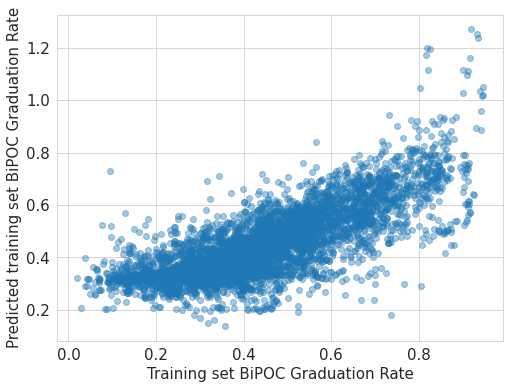

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(y_train, model.predict(sm.add_constant(X_train)), 'o', alpha = 0.4)

plt.xlabel('Training set Total Graduation Rate', fontsize = 15)
plt.ylabel('Predicted training set Total Graduation Rate', fontsize = 15)

plt.tick_params(labelsize = 15);

In [ ]:
y_pred_lr = model.predict(sm.add_constant(X_test))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


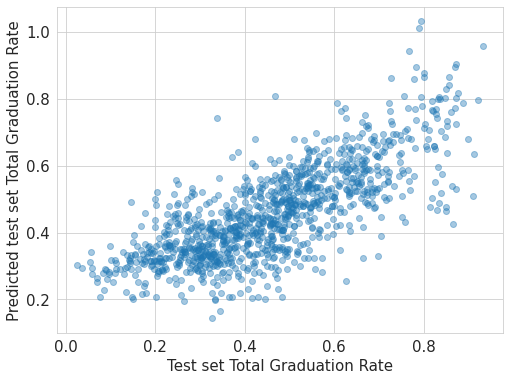

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_lr, 'o', alpha = 0.4);

plt.xlabel('Test set Total Graduation Rate', fontsize = 15)
plt.ylabel('Predicted test set Total Graduation Rate', fontsize = 15)

plt.tick_params(labelsize = 15)

In [ ]:
# Root Mean Squared Error
mean_squared_error(y_test, y_pred_lr, squared = False).round(3)

0.121

In [ ]:
# Mean Absolute Error
mean_absolute_error(y_test, y_pred_lr).round(3)

0.094

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           gr_total_pct   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     660.3
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:49:51   Log-Likelihood:                 3038.7
No. Observations:                4348   AIC:                            -6057.
Df Residuals:                    4338   BIC:                            -5994.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             